In [38]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import time

# --- 1. LECTOR DE GRAFOS (Formato DIMACS) ---
def leer_grafo_dimacs(ruta_archivo):
    """
    Lee un archivo .col y devuelve la matriz de adyacencia y el número de nodos.
    """
    num_nodos = 0
    matriz_adyacencia = None
    
    try:
        with open(ruta_archivo, 'r') as f:
            for linea in f:
                tokens = linea.split()
                if not tokens or tokens[0] == 'c':
                    continue
                
                if tokens[0] == 'p':
                    num_nodos = int(tokens[2])
                    matriz_adyacencia = np.zeros((num_nodos, num_nodos), dtype=int)
                
                elif tokens[0] == 'e':
                    # Restamos 1 porque el archivo usa índice 1 y Python índice 0
                    u, v = int(tokens[1]) - 1, int(tokens[2]) - 1
                    matriz_adyacencia[u, v] = 1
                    matriz_adyacencia[v, u] = 1
                    
        return matriz_adyacencia, num_nodos
    except FileNotFoundError:
        print(f"Error: No se encuentra el archivo {ruta_archivo}")
        return None, 0

In [39]:
# --- 2. CLASE INDIVIDUO ---
class Individuo:
    def __init__(self, num_nodos, max_colores, genes=None):
        self.num_nodos = num_nodos
        # Si no se pasan genes, se generan aleatoriamente (colores 0 a max_colores-1)
        if genes is None:
            self.genes = np.random.randint(0, max_colores, size=num_nodos)
        else:
            self.genes = np.array(genes)
            
        self.fitness = float('inf')
        self.conflictos = 0
        self.num_colores = 0

    def calcular_fitness(self, matriz_adyacencia):
        """
        Calcula el fitness penalizando fuertemente los conflictos.
        Objetivo: Minimizar el valor.
        """
        # 1. Contar conflictos (aristas con nodos del mismo color)
        # Usamos operaciones vectorizadas de numpy para ser más rápidos
        self.conflictos = 0
        for i in range(self.num_nodos):
            # Miramos solo vecinos con índice mayor para no contar doble
            vecinos = np.where(matriz_adyacencia[i] == 1)[0]
            vecinos_mayores = vecinos[vecinos > i]
            
            for v in vecinos_mayores:
                if self.genes[i] == self.genes[v]:
                    self.conflictos += 1

        # 2. Contar colores únicos usados
        self.num_colores = len(np.unique(self.genes))

        # 3. Fórmula de Fitness
        # Penalización grave por conflictos (ej. 1000 puntos por conflicto)
        # Esto asegura que el algoritmo priorice primero encontrar una solución válida
        # y luego reducir colores.
        PENALIZACION = 1000
        self.fitness = (self.conflictos * PENALIZACION) + self.num_colores
        return self.fitness

In [40]:
# --- 3. OPERADORES GENÉTICOS ---

# A. SELECCIÓN
def seleccion_torneo(poblacion, k=3):
    """Elige k individuos al azar y devuelve el mejor (menor fitness)."""
    aspirantes = random.sample(poblacion, k)
    return min(aspirantes, key=lambda ind: ind.fitness)

def seleccion_ruleta_ranking(poblacion):
    """
    Selección por Ruleta basada en Ranking (mejor para minimización).
    Ordena la población y da más probabilidad linealmente a los mejores.
    """
    poblacion_ordenada = sorted(poblacion, key=lambda ind: ind.fitness)
    n = len(poblacion)
    # Pesos: el mejor tiene peso N, el peor peso 1
    pesos = list(range(n, 0, -1))
    return random.choices(poblacion_ordenada, weights=pesos, k=1)[0]

# B. CRUCE (CROSSOVER)
def cruce_un_punto(padre1, padre2):
    """Corta los padres en un punto aleatorio y mezcla las partes."""
    punto = random.randint(1, len(padre1.genes) - 2)
    hijo1_genes = np.concatenate((padre1.genes[:punto], padre2.genes[punto:]))
    hijo2_genes = np.concatenate((padre2.genes[:punto], padre1.genes[punto:]))
    return hijo1_genes, hijo2_genes

def cruce_uniforme(padre1, padre2):
    """Cada gen se elige aleatoriamente de uno de los dos padres."""
    mascara = np.random.randint(0, 2, size=len(padre1.genes)).astype(bool)
    hijo1_genes = np.where(mascara, padre1.genes, padre2.genes)
    hijo2_genes = np.where(mascara, padre2.genes, padre1.genes)
    return hijo1_genes, hijo2_genes

# C. MUTACIÓN
def mutacion_aleatoria(individuo, max_colores, prob_mutacion):
    """Cambia el color de un nodo a uno aleatorio."""
    nuevo_ind = copy.deepcopy(individuo)
    for i in range(len(nuevo_ind.genes)):
        if random.random() < prob_mutacion:
            nuevo_ind.genes[i] = random.randint(0, max_colores - 1)
    return nuevo_ind

def mutacion_intercambio(individuo, max_colores, prob_mutacion):
    """Intercambia el color de dos nodos aleatorios."""
    nuevo_ind = copy.deepcopy(individuo)
    if random.random() < prob_mutacion:
        idx1, idx2 = random.sample(range(len(nuevo_ind.genes)), 2)
        nuevo_ind.genes[idx1], nuevo_ind.genes[idx2] = nuevo_ind.genes[idx2], nuevo_ind.genes[idx1]
    return nuevo_ind

In [41]:
# --- 4. ALGORITMO GENÉTICO PRINCIPAL ---
def ejecutar_genetico(matriz_adyacencia, 
                      num_nodos, 
                      tam_poblacion=100, 
                      max_generaciones=1000, 
                      prob_cruce=0.8, 
                      prob_mutacion=0.1,
                      tipo_seleccion="torneo",
                      tipo_cruce="un_punto",
                      tipo_mutacion="aleatoria",
                      elitismo=True):
    
    # Configuración inicial
    # Inicialmente permitimos tantos colores como nodos (peor caso)
    max_colores_posibles = 20 
    
    # Generar población inicial
    poblacion = []
    for _ in range(tam_poblacion):
        ind = Individuo(num_nodos, max_colores_posibles)
        ind.calcular_fitness(matriz_adyacencia)
        poblacion.append(ind)
        
    mejor_historico = [] # Para graficar
    mejor_global = min(poblacion, key=lambda x: x.fitness)
    
    generacion = 0
    start_time = time.time()
    
    while generacion < max_generaciones:
        nueva_poblacion = []
        
        # 1. Elitismo: Pasar el mejor directamente a la siguiente generación
        if elitismo:
            mejor_actual = min(poblacion, key=lambda x: x.fitness)
            if mejor_actual.fitness < mejor_global.fitness:
                mejor_global = copy.deepcopy(mejor_actual)
            nueva_poblacion.append(copy.deepcopy(mejor_global))
            
        # 2. Bucle de evolución
        while len(nueva_poblacion) < tam_poblacion:
            # Selección
            if tipo_seleccion == "torneo":
                p1 = seleccion_torneo(poblacion)
                p2 = seleccion_torneo(poblacion)
            else: # ruleta
                p1 = seleccion_ruleta_ranking(poblacion)
                p2 = seleccion_ruleta_ranking(poblacion)
                
            # Cruce
            if random.random() < prob_cruce:
                if tipo_cruce == "un_punto":
                    genes_h1, genes_h2 = cruce_un_punto(p1, p2)
                else: # uniforme
                    genes_h1, genes_h2 = cruce_uniforme(p1, p2)
                hijo1 = Individuo(num_nodos, max_colores_posibles, genes_h1)
                hijo2 = Individuo(num_nodos, max_colores_posibles, genes_h2)
            else:
                hijo1 = copy.deepcopy(p1)
                hijo2 = copy.deepcopy(p2)
                
            # Mutación
            if tipo_mutacion == "aleatoria":
                hijo1 = mutacion_aleatoria(hijo1, max_colores_posibles, prob_mutacion)
                hijo2 = mutacion_aleatoria(hijo2, max_colores_posibles, prob_mutacion)
            else: # intercambio
                hijo1 = mutacion_intercambio(hijo1, max_colores_posibles, prob_mutacion)
                hijo2 = mutacion_intercambio(hijo2, max_colores_posibles, prob_mutacion)
            
            # Calcular fitness de hijos
            hijo1.calcular_fitness(matriz_adyacencia)
            hijo2.calcular_fitness(matriz_adyacencia)
            
            nueva_poblacion.extend([hijo1, hijo2])
            
        # Recortar si nos pasamos del tamaño de población
        poblacion = nueva_poblacion[:tam_poblacion]
        
        # Guardar datos para gráfica
        mejor_gen = min(poblacion, key=lambda x: x.fitness)
        mejor_historico.append(mejor_gen.fitness)
        
        # Criterio de parada por "Estado Estacionario" (opcional)
        # Si llevamos 100 generaciones sin mejora, paramos
        # (Implementación simplificada para no alargar el código)
        
        generacion += 1
        
    tiempo_total = time.time() - start_time
    return mejor_global, mejor_historico, tiempo_total

Ejecutando GA para grafo con 87 nodos...
------------------------------
Mejor Fitness: 1019
Colores Usados: 19
Conflictos: 1
Tiempo: 54.1777 segundos
Asignación de colores: [ 7  7  3 12  4 10  3 13 17 12  8  6  6  9  5 15 15 14  5 15  4  1 15  1
  2 13 17 16  6  3 10 16 17 13 14 19 10  8 17 14  6  3  4 13 14  3  2  8
  3 13 14 18 14  9  8 10  8  2 16 16  8 16 14  1 18 18  4  9  8 10  1  9
 12  2 17 16 19  6 13 14 12 12 11  6 15 14 19]
------------------------------


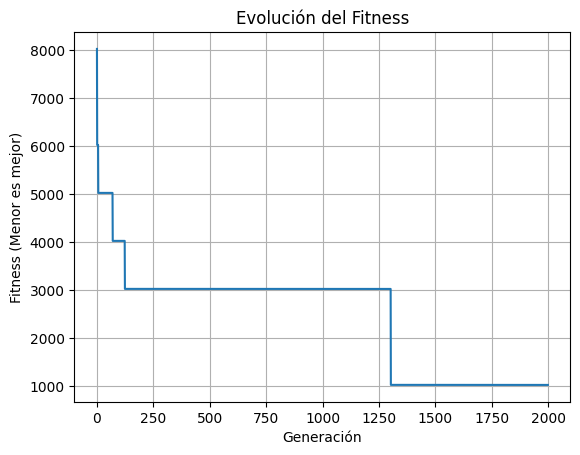

In [42]:
# --- 5. EJECUCIÓN Y PRUEBAS ---

# Configuración de archivo
archivo = "87,406.col" # Asegúrate de que el archivo está en la misma carpeta
matriz, n_nodos = leer_grafo_dimacs(archivo)

if matriz is not None:
    print(f"Ejecutando GA para grafo con {n_nodos} nodos...")
    
    # Ejecutar algoritmo
    mejor_solucion, historial, tiempo = ejecutar_genetico(
        matriz, 
        n_nodos,
        tam_poblacion=150,
        max_generaciones=2000,
        prob_cruce=0.8,
        prob_mutacion=0.2,
        tipo_seleccion="torneo",  # Puedes cambiar a 'ruleta'
        tipo_cruce="un_punto",    # Puedes cambiar a 'uniforme'
        tipo_mutacion="aleatoria" # Puedes cambiar a 'intercambio'
    )
    
    # Mostrar resultados
    print("-" * 30)
    print(f"Mejor Fitness: {mejor_solucion.fitness}")
    print(f"Colores Usados: {mejor_solucion.num_colores}")
    print(f"Conflictos: {mejor_solucion.conflictos}")
    print(f"Tiempo: {tiempo:.4f} segundos")
    print(f"Asignación de colores: {mejor_solucion.genes}")
    print("-" * 30)
    
    # Gráfica de evolución
    plt.plot(historial)
    plt.title("Evolución del Fitness")
    plt.xlabel("Generación")
    plt.ylabel("Fitness (Menor es mejor)")
    plt.grid(True)
    plt.show()
    
    # 
else:
    print("No se pudo cargar el grafo.")